In [11]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [12]:
df = pd.read_csv('Validation error of 100 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,44.566953,0.675069,-3.208304,-18.054741,1.617269,1.429603,-37.614259,2.024533e+27,1666.666687,...,-5.884384,-14.838882,-14.838882,2.926806e+27,1677.917838,-16.096247,8.593312e+07,-5.979550,-15.051019,-9.257346
1,0,31.641783,44.035059,-13.933470,29.672280,-9.033302,-4.258640,3.684138,2.024533e+27,1000.000000,...,-13.047982,-9.466183,-11.257083,2.665132e+27,1440.350592,-11.229945,7.957511e+07,-11.869318,-9.063053,-11.671809
2,0,-8.139972,-26.534045,-1.439523,47.908442,3.598805,-0.378739,53.026766,3.036800e+27,2000.000000,...,-7.675284,-7.675284,-7.675284,2.789605e+27,1469.319105,-5.799677,8.272342e+07,-7.951503,-7.646215,-11.745239
3,0,11.836865,40.281602,-26.678038,0.801196,82.522124,8.628562,-35.910392,2.530667e+27,1111.111112,...,-2.302585,-11.257083,-16.629781,2.830218e+27,1558.684468,-13.506405,8.378234e+07,-4.202727,-12.228407,-10.657962
4,0,4.118205,-17.124449,73.970318,35.935756,-34.671342,0.500379,-25.638311,2.783733e+27,1777.777791,...,-14.838882,-7.675284,-14.838882,2.898373e+27,1473.343134,-4.005814,8.341877e+07,-9.694042,-7.713689,-11.034443


In [13]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.000000,...,99.000000,99.000000,99.000000,9.900000e+01,99.000000,99.000000,9.900000e+01,99.000000,99.000000,99.000000
mean,0.0,14.862834,10.475780,5.293246,8.579865,13.423291,10.225058,35.578395,2.678928e+27,1448.933791,...,-10.081240,-10.768655,-10.605846,2.834376e+27,1532.651112,-9.829098,8.339401e+07,-10.179380,-10.731329,-10.032907
std,0.0,35.187100,23.832341,28.628807,19.133096,34.364433,32.962582,107.722255,7.257631e+26,299.036498,...,5.001459,5.128472,4.924256,1.093049e+26,76.149884,4.213800,2.789792e+06,4.046561,4.244110,1.248067
min,0.0,-30.537286,-29.150604,-34.932039,-19.069993,-44.689067,-31.897309,-56.945068,1.518400e+27,1000.000000,...,-18.420681,-18.420681,-18.420681,2.561439e+27,1398.786724,-18.250466,7.660079e+07,-19.116153,-18.546457,-12.059723
25%,0.0,-13.711737,-10.751780,-12.624689,-7.725789,-8.750036,-8.775045,-31.676216,2.024533e+27,1222.222224,...,-14.838882,-14.838882,-14.838882,2.770209e+27,1469.284713,-12.931051,8.150682e+07,-13.514656,-14.807444,-11.013140
50%,0.0,0.464554,6.176572,-1.137342,4.985372,4.963822,1.429603,-5.211300,2.783733e+27,1444.444448,...,-9.466183,-11.257083,-11.257083,2.838405e+27,1526.424885,-9.598559,8.323129e+07,-9.694042,-9.895992,-10.115379
75%,0.0,38.476692,30.289960,10.271214,25.384933,25.098941,12.761983,50.069174,3.289867e+27,1666.666687,...,-5.884384,-5.884384,-7.675284,2.900268e+27,1585.933149,-5.561378,8.531734e+07,-6.835907,-6.660809,-9.369899
max,0.0,94.451827,58.790421,109.522074,51.558475,142.074305,141.183388,414.097428,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,3.051743e+27,1702.510476,-3.932063,8.907846e+07,-3.859137,-3.976435,-6.217353


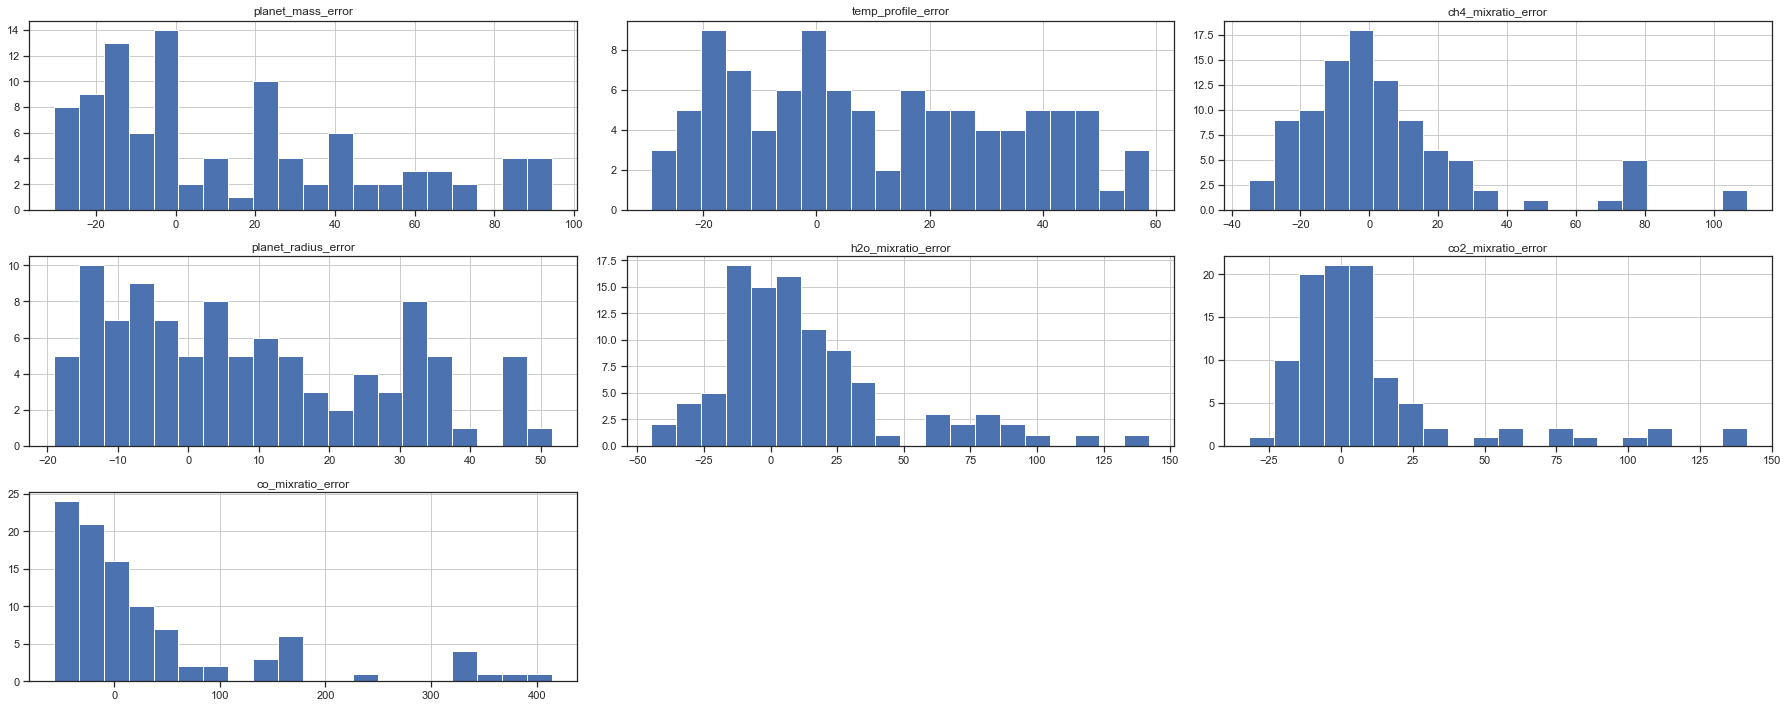

In [14]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

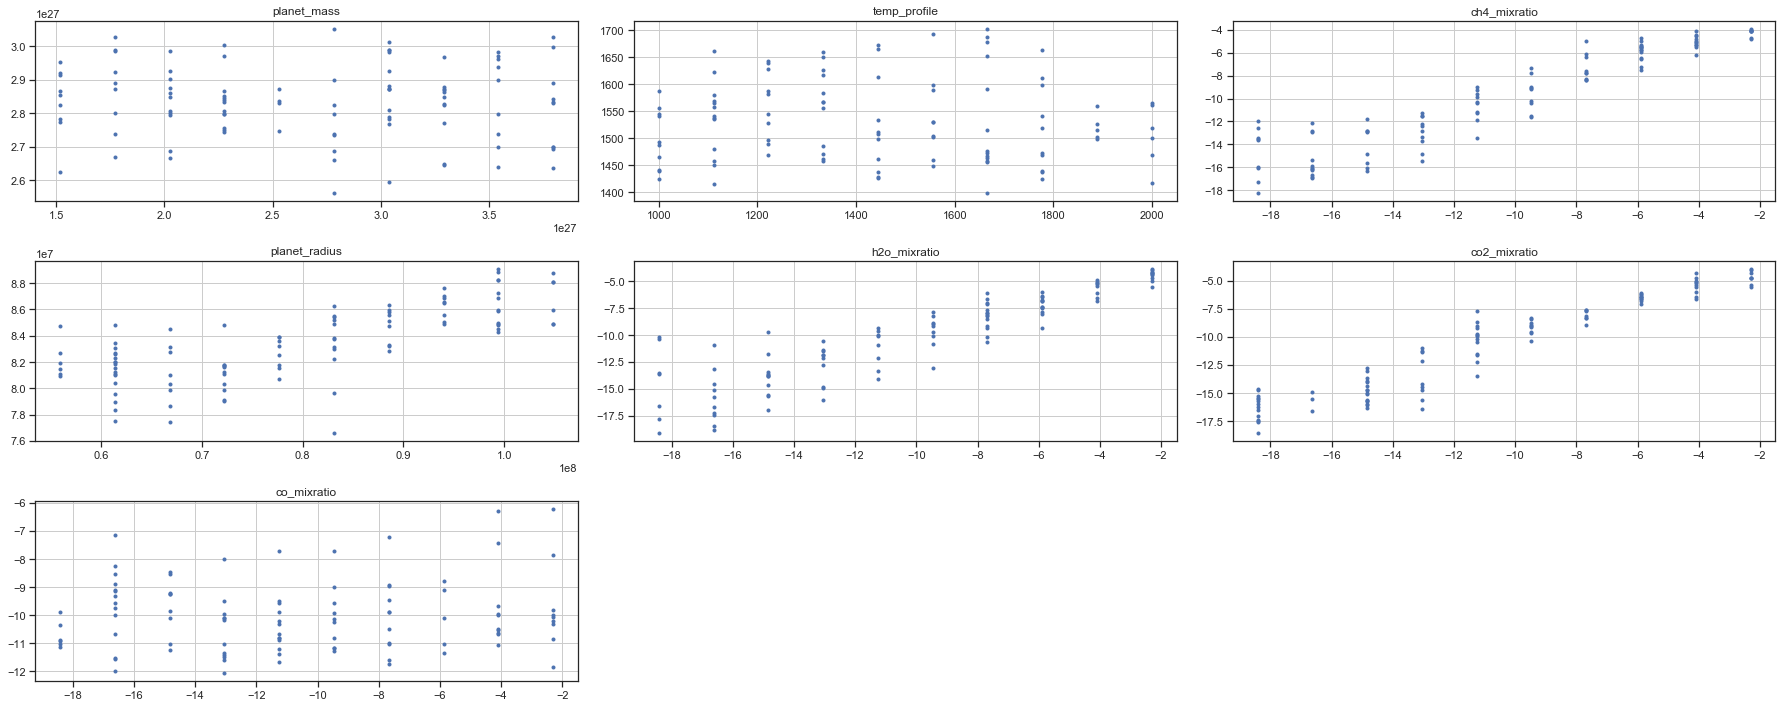

In [15]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param)
    plt.plot(df[param+'_real'], df[param+'_inpainted'], '.')
    plt.grid()
    plt.tight_layout()